In [1]:
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import numpy as np
import datacube
import xarray as xr
import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize
from deafrica_dask import create_local_dask_cluster
from deafrica_classificationtools import HiddenPrints

In [ ]:
create_local_dask_cluster()


## Cropped area

### Total for AEZ

In [ ]:
cropmask=xr.open_rasterio('../eastern_cropmask/results/classifications/predicted/20210301/Eastern_gm_mads_two_seasons_20210301_mosaic_clipped.tif',
                         chunks={'x':10000, 'y':10000})

cropmask = cropmask.persist()

In [ ]:
pixel_length = 20  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [ ]:
total_area = cropmask.sum(dim=['x', 'y']) * area_per_pixel

In [ ]:
total_area = total_area.compute()

In [ ]:
print(round(float(total_area.values),2), ' km2')
print(round(float(total_area.values*100),2), ' Mha')

### Area per country

In [ ]:
afr = gpd.read_file('data/african_countries.shp')
afr = afr.to_crs('epsg:6933')

In [ ]:
e = afr[afr['COUNTRY'] == 'Ethiopia']
t = afr[afr['COUNTRY'] == 'Tanzania']
k = afr[afr['COUNTRY'] == 'Kenya']
u = afr[afr['COUNTRY'] == 'Uganda']
r = afr[afr['COUNTRY'] == 'Rwanda']
b = afr[afr['COUNTRY'] == 'Burundi']

countries = [e,t,k,u,r,b]

In [ ]:
areas={}
for country in countries:
    #make sure we have 1 polygon per country
    country['agg'] = 1     
    c=country.dissolve(by='agg',  aggfunc='sum')
    print(c['COUNTRY'].values[0][0:3])
    
    #create mask
    with HiddenPrints():
        mask = xr_rasterize(c,cropmask)
    mask = mask.chunk({'x':10000, 'y':10000})
    ds = cropmask.where(mask).astype('float32')
    
    area = ds.sum(dim=['x', 'y']) * area_per_pixel
    area = area.compute()
    print(area.values)
    
    areas[c['COUNTRY'].values[0][0:3]] = area.values
    
    del ds

In [ ]:
for key,value in areas.items():
    print(key, round(value[0]*100/1e6,2), ' Mha')

## Plotting all reference data

### Validation

In [3]:
c=gpd.read_file('../central_cropmask/data/validation_samples.shp')
e=gpd.read_file('../eastern_cropmask/data/validation_samples.shp')
i=gpd.read_file('../indian_ocean_cropmask/data/validation_samples.shp')
n=gpd.read_file('../northern_cropmask/data/validation_samples.shp')
sa=gpd.read_file('../sahel_cropmask/data/validation_samples.shp')
so=gpd.read_file('../southern_cropmask/data/validation_samples.shp')
w=gpd.read_file('../western_cropmask/data/validation_samples.shp')

val = pd.concat([c,e,i,n,sa,so,w]).reset_index(drop=True)

In [4]:
print('non-crop length: '+str(len(val[val['Class']=='non-crop'])))
print('crop length: '+str(len(val[val['Class']=='crop'])))

non-crop length: 1200
crop length: 600


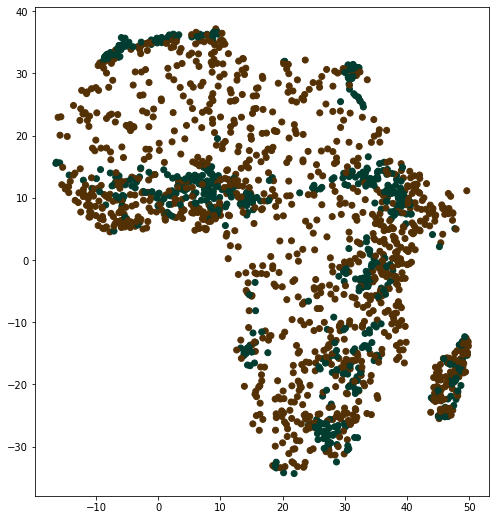

In [5]:
val.plot(column='Class', figsize=(12,9), cmap='BrBG_r')

In [ ]:
val.to_file('crop_training_africa_20210329.shp')

### Training

In [6]:
c=gpd.read_file('../central_cropmask/data/ceo_td_polys.geojson')
e=gpd.read_file('../eastern_cropmask/data/Eastern_training_data_20210301.geojson')
i=gpd.read_file('../indian_ocean_cropmask/data/Indian_ocean_training_data_20210115.geojson')
n=gpd.read_file('../northern_cropmask/data/ceo_td_polys.geojson')
sa=gpd.read_file('../sahel_cropmask/data/ceo_td_polys.geojson')
so=gpd.read_file('../southern_cropmask/data/ceo_td_polys.geojson')
w=gpd.read_file('../western_cropmask/data/ceo_td_polys.geojson')

td = pd.concat([c,e,i,n,sa,so,w]).reset_index(drop=True)

In [7]:
td = td.to_crs('epsg:6933')
td['geometry'] = td['geometry'].centroid
td = td.to_crs('epsg:4326')

In [8]:
td['Class'] = np.where(td['Class']=='1', 'crop', td['Class'])
td['Class'] = np.where(td['Class']=='0', 'non-crop', td['Class'])

td['Class'] = np.where(td['Class']==1, 'crop', td['Class'])
td['Class'] = np.where(td['Class']==0, 'non-crop', td['Class'])

In [9]:
print('non-crop length: '+str(len(td[td['Class']=='non-crop'])))
print('crop length: '+str(len(td[td['Class']=='crop'])))

non-crop length: 7596
crop length: 3928


In [10]:
td['Class'].unique()

array(['non-crop', 'crop'], dtype=object)

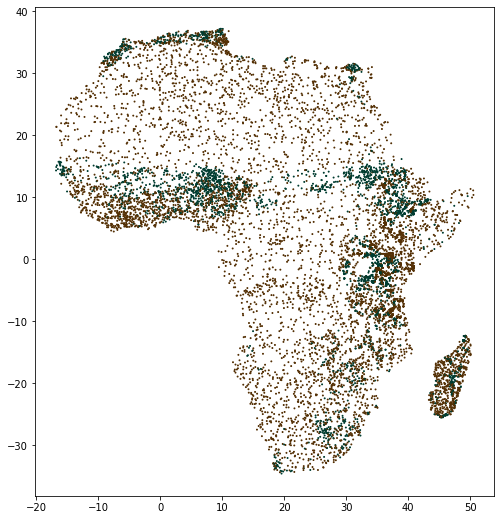

In [11]:
td.plot(column='Class', figsize=(12,9), cmap='BrBG_r', markersize =0.9)

In [ ]:
td.to_file('crop_validation_africa_20210329.shp')